In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from pandas import Series
import statsmodels.api as sm
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [73]:
letter = "J"
def analiza_szeregu(letter):
    def difference(dataset, interval=1):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        return Series(diff)
    display("Analiza szeregu: "+ letter)

    df = pd.read_csv("dane_projekt.csv", sep = ";", header = None, index_col=0 )

    def plot1(letter):
        fig = plt.figure()
        x = np.arange(0,42,1)
        (plt.plot(x, Series(df.loc[letter,:].astype(np.float)), '-b', label='Oryginalny szereg'))
        (plt.plot(np.arange(0,41,1), difference(list(df.loc[letter,:])), '-g', label='Szereg zróżnicowany'))
        plt.legend()
        display(fig)
        #fig.show()

    plot1(letter)

    def plot_acf_pacf(letter):
        szereg = difference(list(df.loc[letter,:]))
        display(sm.graphics.tsa.plot_acf(szereg, lags=20))
        display(sm.graphics.tsa.plot_pacf(szereg, lags=20))

    plot_acf_pacf(letter)

    #sMAPE - Symmetric Mean Absolute Percentage Error
    def smape(y_true, y_pred):
        return np.mean((np.abs(200*(np.array(y_true) - np.array(y_pred))/(np.array(y_true) + np.array(y_pred )))))
    #MAE - Mean Absolute Error
    def mae(y_true, y_pred):
        return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))
    #SSE - Sum of Squared Errors
    def sse(y_true, y_pred):
        return np.sum((np.array(y_true) - np.array(y_pred))**2)
    #MSE - Mean Square Error
    def mse(y_true, y_pred):
        return np.mean((np.array(y_true) - np.array(y_pred))**2)
    #RMSE - Root Mean Square Error
    def rmse(y_true, y_pred):
        return np.sqrt(mse(np.array(y_true), np.array(y_pred)))


    p = 11
    q = 11
    diff = 3
    ts = Series(df.loc[letter,1:].astype(np.float))[:30]
    aic = []
    bic = []
    mape_val = []
    smape_val = []
    mae_val = []
    sse_val = []
    mse_val = []
    rmse_val = []
    p_param = []
    q_param = []
    diff_param = []

    for i in range(1, p):
        for j in range(1, q):
            for k in range(0, diff):
                dane = ts.diff(periods = k)
                try:
                    model = sm.tsa.ARMA(dane[k:30], (i,j)).fit()
                    diff_param.append(k)
                    p_param.append(i)
                    q_param.append(j)
                    aic.append(model.aic)
                    bic.append(model.bic)

                    smape_val.append(smape(dane[k:30], model.predict())) 
                    mae_val.append(mae(dane[k:30], model.predict())) 
                    sse_val.append(sse(dane[k:30], model.predict())) 
                    mse_val.append(mse(dane[k:30], model.predict())) 
                    rmse_val.append(rmse(dane[k:30], model.predict())) 
                except:
                    pass


    display("Kryteria informacyjne w zależności od dobranych parametrów modelu ARIMA")
    ts_result = pd.DataFrame({'p_param': p_param,
        'q_param': q_param,
        'diff_param': diff_param,
        'aic': aic,
        'bic': bic
    })

    display(ts_result.sort_values('aic'))

    display("Ocena dopasowania predykcji: ")

    ts_result1 = pd.DataFrame({

        'smape': smape_val,
        'mae': mae_val,
        'sse': sse_val,
        'mse': mse_val,
        'rmse': rmse_val })

    display(ts_result1)

    d = ts_result.sort_values("aic").iloc[0,:].diff_param
    p = ts_result.sort_values("aic").iloc[0,:].p_param
    q = ts_result.sort_values("aic").iloc[0,:].q_param

    display("Parametry modelu ARIMA(p,d,q) zostały dobrane na podstawie minimalizacji AIC")
    display("parametr różnicowania: d = " + str(d))
    display("parametr p = "+str(p))
    display("parametr q = "+ str( q))
    display("Poniższe prognozy są wyznaczone przy użyciu modelu ARIMA("+str(p)+","+str(d)+","+str(q)+")")

    ts_np = np.array( df.loc[letter,:])
    from statsmodels.tsa.arima_model import ARIMA
    model = ARIMA(ts_np, order=(int(p),int(d),int(q)))
    model_fit = model.fit(disp=0)
    display(model_fit.summary())
    # plot residual errors
    pred = model_fit.forecast()
    #
    residuals = pd.DataFrame(model_fit.resid)
    display("Ocena rozkładu błędów - reszty z modelu powinny być białym szumem")
    display(residuals.plot(title = "Szereg czasowy reszt z modelu ARIMA"))

    display(residuals.plot(kind='kde', title = "Wykres gęstości reszt z modelu ARIMA"))

    def difference(dataset, interval=1):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        return Series(diff)

    ts_diff = difference(ts_np, interval=int(d))

    pred = model_fit.predict()
    pred = pd.DataFrame(pred)
    pred.plot()
    plt.title("Analiza dokładności prognoz")
    display(plt.plot(ts_diff, color='red'))

    pred_next_year = model_fit.forecast(12)[0]
    df=pd.read_csv("prognozy.csv", header = None, sep = ";",index_col=0)
    ts_prog = df.loc[letter,:]
    ts_pd_prog = ts
    ts_np_prog = np.array(ts)

    display("Predykcja na kolejny rok")

    display(pred_next_year)

    pd.DataFrame(pred_next_year).to_csv("prognoza"+letter+".csv")

    import skfuzzy as fuzz
    from skfuzzy import control as ctrl

    a = ts
    max_for_universe=np.max(a)
    # print(max_for_universe)
    universe = np.arange(0, max_for_universe, 1)
    # print(universe)
    names_3 = ['low', 'medium', 'high']

    fcst_arma = ctrl.Antecedent(universe, 'fcst_arma')
    fcst_expert = ctrl.Antecedent(universe, 'fcst_expert')
    fcst_final = ctrl.Consequent(universe, 'fcst_final')

    def q(x):
        return a.quantile(x)

    fcst_arma['low'] = fuzz.trapmf(fcst_arma.universe, [0, 0, q(0.25), q(0.4)])
    fcst_arma['medium'] = fuzz.trapmf(fcst_arma.universe, [q(0.25), q(0.3), q(0.6), q(0.8)])
    fcst_arma['high'] = fuzz.trapmf(fcst_arma.universe, [q(0.65), q(0.8) , q(1), q(1)])

    fcst_expert['low'] = fuzz.trapmf(fcst_arma.universe, [0, 0, q(0.25), q(0.4)])
    fcst_expert['medium'] = fuzz.trapmf(fcst_arma.universe, [q(0.25), q(0.3), q(0.6), q(0.8)])
    fcst_expert['high'] = fuzz.trapmf(fcst_arma.universe, [q(0.65), q(0.8) , q(1), q(1)])

    fcst_final['low'] = fuzz.trapmf(fcst_arma.universe, [0, 0, q(0.25), q(0.4)])
    fcst_final['medium'] = fuzz.trapmf(fcst_arma.universe, [q(0.25), q(0.3), q(0.6), q(0.8)])
    fcst_final['high'] = fuzz.trapmf(fcst_arma.universe, [q(0.65), q(0.8) , q(1), q(1)])


    rule1 = ctrl.Rule(fcst_arma['high'] | fcst_expert['high'], fcst_final['high'])
    rule2 = ctrl.Rule(fcst_arma['low'], fcst_final['low'])
    rule3 = ctrl.Rule(fcst_arma['medium'] | fcst_expert['medium'], fcst_final['medium'])

    final_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])

    final = ctrl.ControlSystemSimulation(final_ctrl)

    arma_p = []
    ekspert = []
    ostatecznie = []
    for i in range(len(pred_next_year)):
        final.input['fcst_arma'] = pred_next_year[i]
        arma_p.append(pred_next_year[i])
        final.input['fcst_expert'] = ts_np_prog[i]
        ekspert.append(ts_np_prog[i])
        final.compute()
        ostatecznie.append(final.output['fcst_final'])



    ts_result = pd.DataFrame({
        'arma_p': arma_p,
        'ekspert': ekspert,
        'wnioskowanie rozmyte': ostatecznie
    })

    display(ts_result)






'Analiza szeregu: J'

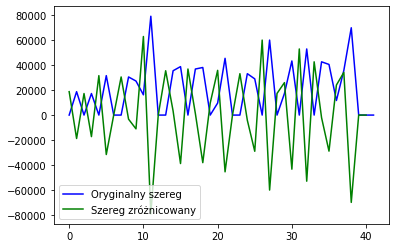

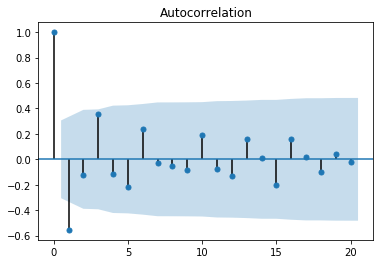

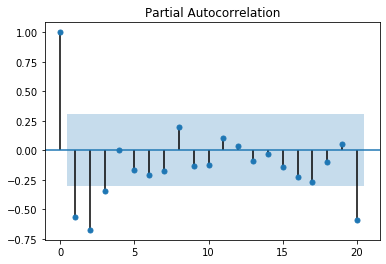

'Kryteria informacyjne w zależności od dobranych parametrów modelu ARIMA'

,p_param,q_param,diff_param,aic,bic
2,2,1,2,637.057337,643.718359
9,3,2,2,637.137138,646.462570
7,3,1,2,638.475328,646.468555
10,3,3,2,638.820816,649.478452
4,2,2,2,638.993702,646.986929
13,4,1,2,639.021030,648.346461
5,2,3,2,639.884229,649.209661
16,5,1,2,639.917228,650.574864
23,7,1,2,641.099405,654.421450
22,6,4,2,641.804105,657.790560


'Ocena dopasowania predykcji: '

,smape,mae,sse,mse,rmse
0,187.400453,19381.466266,1.778860e+10,6.353072e+08,25205.301664
1,108.947297,14944.369775,1.025532e+10,3.536319e+08,18805.102259
2,137.176699,13498.795117,7.709346e+09,2.753338e+08,16593.184652
3,105.352110,14976.572961,1.023179e+10,3.528205e+08,18783.515588
4,136.469392,13427.216036,7.701483e+09,2.750530e+08,16584.721255
5,104.564218,11533.458033,7.584512e+09,2.708754e+08,16458.293372
6,84.757130,12377.709054,7.783040e+09,2.683807e+08,16382.328822
7,209.338652,13029.576716,7.752365e+09,2.768702e+08,16639.416712
8,124.629586,18400.265075,1.464454e+10,5.049842e+08,22471.853643
9,134.133335,11260.008601,6.888622e+09,2.460222e+08,15685.095657


'Parametry modelu ARIMA(p,d,q) zostały dobrane na podstawie minimalizacji AIC'

'parametr różnicowania: d = 2.0'

'parametr p = 2.0'

'parametr q = 1.0'

'Poniższe prognozy są wyznaczone przy użyciu modelu ARIMA(2.0,2.0,1.0)'

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                   40
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -460.982
Method:                       css-mle   S.D. of innovations          22486.622
Date:                Wed, 01 Apr 2020   AIC                            931.964
Time:                        21:55:38   BIC                            940.408
Sample:                             2   HQIC                           935.017
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -142.2949    126.519     -1.125      0.268    -390.268     105.679
ar.L1.D2.y    -0.8902      0.120     -7.433      0.000      -1.125      -0.656
ar.L2.D2.y    -0.6087      0.117     -5.220      0.000      -0.837      -0.380
ma.L1.D2.y    -1.0000      0.073    -13.644      0.000      -1.144      -0.856
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7313           -1.0527j            1.2818           -0.3466
AR.2           -0.7313           +1.0527j            1.2818            0.3466
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

'Ocena rozkładu błędów - reszty z modelu powinny być białym szumem'

'Predykcja na kolejny rok'

array([ -6671.93200806,  -7759.77019878, -10113.51160625, -15094.65481882,
       -17321.84092173, -20757.13125644, -25148.70098944, -28309.20688084,
       -32339.20170339, -36700.01043076, -40592.67481984, -45056.33339296])

,arma_p,ekspert,wnioskowanie rozmyte
0,-6671.932008,0.0,14707.692083
1,-7759.770199,18696.0,14707.692083
2,-10113.511606,0.0,14707.692083
3,-15094.654819,17200.0,14707.692083
4,-17321.840922,0.0,14707.692083
5,-20757.131256,31500.0,30870.388148
6,-25148.700989,0.0,14707.692083
7,-28309.206881,0.0,14707.692083
8,-32339.201703,30440.0,26553.653972
9,-36700.010431,27180.0,14707.692083


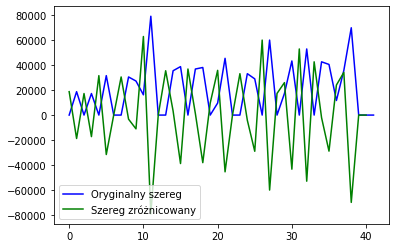

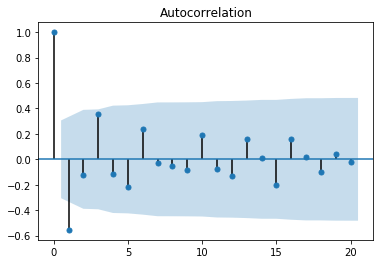

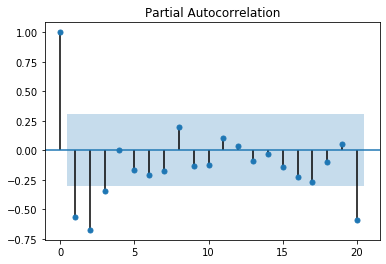

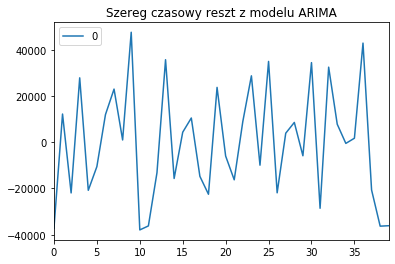

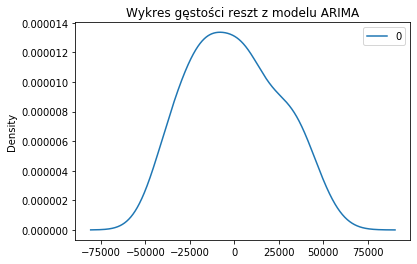

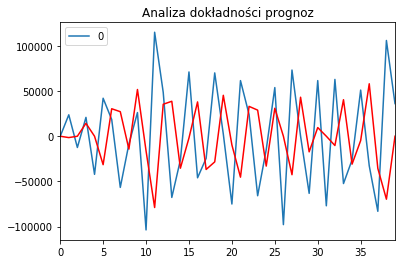

In [75]:
analiza_szeregu("J")

'Analiza szeregu: E'

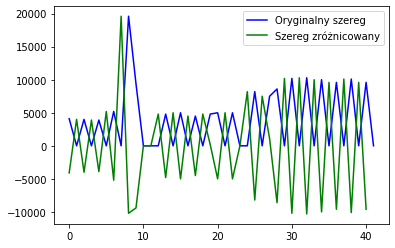

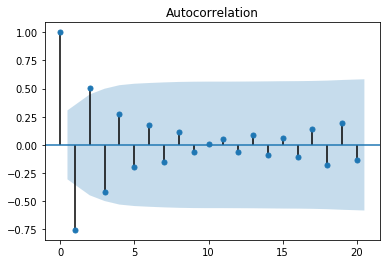

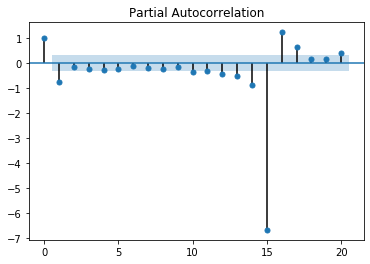

'Kryteria informacyjne w zależności od dobranych parametrów modelu ARIMA'

,p_param,q_param,diff_param,aic,bic
4,3,2,2,568.225473,577.550905
9,5,2,2,571.604022,583.593863
6,4,1,2,572.639384,581.964815
8,5,1,2,573.686429,584.344065
12,7,1,2,574.275919,587.597964
10,6,1,2,575.326451,587.316291
17,10,1,2,579.150408,596.469067
0,1,1,1,579.842820,585.312003
18,10,3,2,581.872886,601.855953
16,9,2,2,582.259858,599.578516


'Ocena dopasowania predykcji: '

,smape,mae,sse,mse,rmse
0,103.991427,3561.201245,6.157945e+08,2.123429e+07,4608.068101
1,103.599269,3403.030583,6.083920e+08,2.097904e+07,4580.287785
2,96.394347,3228.754515,5.769148e+08,1.989361e+07,4460.225641
3,100.915007,3470.546636,6.066071e+08,2.091749e+07,4573.563795
4,201.289337,3320.852822,6.340374e+08,2.264419e+07,4758.591559
5,106.514742,3464.072118,5.991028e+08,2.065872e+07,4545.186046
6,185.065197,3747.239340,7.308802e+08,2.610286e+07,5109.096226
7,104.777221,3333.185430,5.914602e+08,2.039518e+07,4516.102135
8,188.723358,3678.880657,7.123082e+08,2.543958e+07,5043.766406
9,366.940794,3208.669370,6.207809e+08,2.217074e+07,4708.582021


'Parametry modelu ARIMA(p,d,q) zostały dobrane na podstawie minimalizacji AIC'

'parametr różnicowania: d = 2.0'

'parametr p = 3.0'

'parametr q = 2.0'

'Poniższe prognozy są wyznaczone przy użyciu modelu ARIMA(3.0,2.0,2.0)'

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

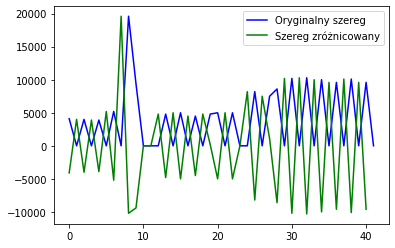

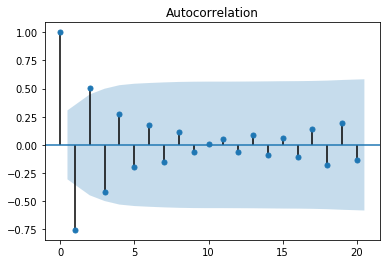

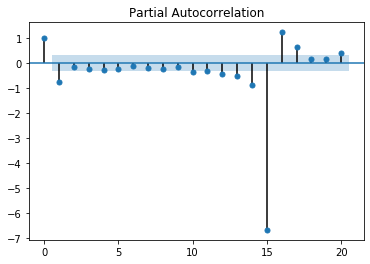

In [76]:
analiza_szeregu("E")